# File Discovery

Dicovers lidar files to be used in the project.

In [1]:
import geopandas as gpd
import pandas as pd
import os
from datetime import datetime
import boto3
import zipfile
import shapely
import numpy as np
import botocore.exceptions
from io import BytesIO

In [2]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

In [3]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
lp(f"Datapath:  {dataPath}")

[2025-03-28 19:12:46.775215] Datapath:  ./datasets/


<Axes: >

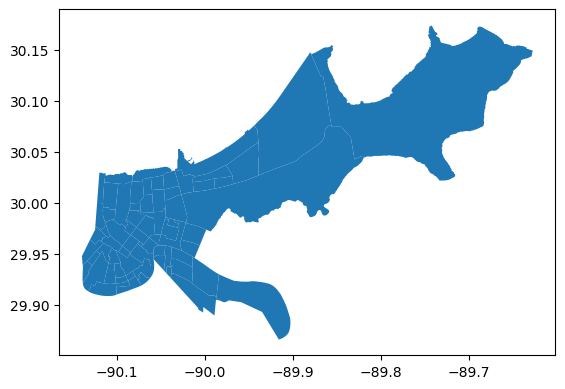

In [4]:
neighborhoodsDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson")
neighborhoodsDf.plot()

In [5]:
lp(f"New Orleans boundary:  {neighborhoodsDf.total_bounds}")

[2025-03-28 19:12:47.261444] New Orleans boundary:  [-90.14003674  29.8656102  -89.62778614  30.17481061]


In [6]:
tileIndex = gpd.read_file(f"{dataPath}UpperDeltaPlainLATileIndex.shp").to_crs(neighborhoodsDf.crs)
tileIndex.head()

,TILENAME,geometry
0,15RYP545750,"POLYGON ((-90.34886 30.48033, -90.3485 30.4938..."
1,15RYP560750,"POLYGON ((-90.33325 30.48001, -90.33288 30.493..."
2,15RYP575750,"POLYGON ((-90.31764 30.47969, -90.31727 30.493..."
3,15RYP590750,"POLYGON ((-90.30203 30.47937, -90.30166 30.492..."
4,15RYP605750,"POLYGON ((-90.28642 30.47905, -90.28604 30.492..."


In [7]:
nolaTileMask = tileIndex.intersects(neighborhoodsDf.union_all())
lp(f"{np.count_nonzero(nolaTileMask)} files found")

[2025-03-28 19:12:47.623439] 305 files found


<Axes: >

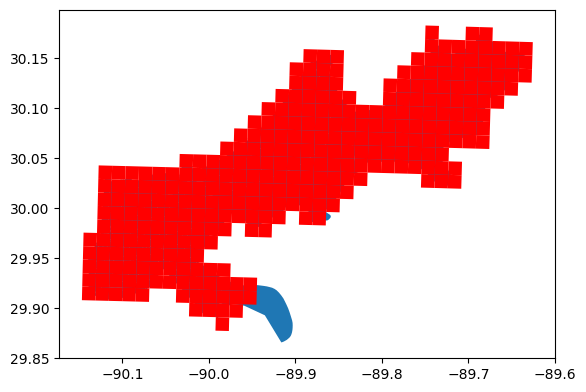

In [8]:
ax = neighborhoodsDf.plot()
tileIndex[nolaTileMask].plot(color='red', ax=ax)

In [9]:
lazPath = f'{dataPath}lazUpperPlainsDelta{os.sep}'

In [10]:
s3UsgsPath = "Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/"
lidarS3Keys = [(s3UsgsPath + name, lazPath + name) for name in tileIndex.loc[nolaTileMask,'TILENAME'].map(lambda name: f"USGS_LPC_LA_UpperDeltaPlain_2015_{name.lower()}.laz").to_list()]
lidarS3Keys[:5]

[('Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp130420.laz',
  './datasets/lazUpperPlainsDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp130420.laz'),
 ('Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp175420.laz',
  './datasets/lazUpperPlainsDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp175420.laz'),
 ('Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp190420.laz',
  './datasets/lazUpperPlainsDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp190420.laz'),
 ('Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp130405.laz',
  './datasets/lazUpperPlainsDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp130405.laz'),
 ('Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp145405.laz',
  './datasets/lazUpperPlainsDelta/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp145405.la

In [11]:
lp(f"Checking for {lazPath}")
if not os.path.exists(lazPath):
    lp(f"Creating LAZ path {lazPath}")
    os.makedirs(lazPath)


[2025-03-28 19:12:47.814982] Checking for ./datasets/lazUpperPlainsDelta/


In [ ]:
startTime = datetime.now()
filesDownloaded = 0
s3Client = boto3.client('s3')
failures = []

for idx, key in enumerate(lidarS3Keys):
    if os.path.exists(key[1]):
        lp(f"{key[1]} already exists skipping [{idx}]!")
        continue

        
    lp(f"Downloading[{idx}] {key[0]}")

    try:
        dlStartTime = datetime.now()
        with BytesIO() as b:
            s3Client.download_fileobj('usgs-lidar', key[0], b, ExtraArgs={'RequestPayer':'requester'})

            b.seek(0)
            with open(key[1], 'wb') as f:
                f.write(b.read())
        
        lp(f"DL Time:  {datetime.now() - dlStartTime}")
    except botocore.exceptions.ClientError as e:
        lp(f"Failed:  {e}")
        failures.append((e,key[0],key[1]))

    filesDownloaded += 1

lp(f"{filesDownloaded} files downloaded in {datetime.now() - startTime}")



[2025-03-28 19:12:47.996705] Downloading[0] Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp130420.laz
[2025-03-28 19:12:51.177379] DL Time:  0:00:03.180591
[2025-03-28 19:12:51.177712] Downloading[1] Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp175420.laz
[2025-03-28 19:12:53.235355] DL Time:  0:00:02.057608
[2025-03-28 19:12:53.235673] Downloading[2] Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp190420.laz
[2025-03-28 19:12:54.904519] DL Time:  0:00:01.668810
[2025-03-28 19:12:54.904621] Downloading[3] Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp130405.laz
[2025-03-28 19:12:56.335318] DL Time:  0:00:01.430667
[2025-03-28 19:12:56.335567] Downloading[4] Projects/LA_UpperDeltaPlain_2015/LA_UpperDeltaPlain_2017/LAZ/USGS_LPC_LA_UpperDeltaPlain_2015_15rzp145405.laz
[2025-03-28 19

In [ ]:
lp(f"Download failures {len(failures)}")

In [ ]:
if len(failures) > 0:
    pd.DataFrame(failures, columns=['Error', 'RemotePath','LocalPath']).to_csv(f'LAZDownloadFailures.csv')

In [ ]:
lp("Done!")